In [1]:
import sys
sys.path.append('..')

In [2]:
# Utility Functions for Inference in a Jupyter Notebook
import matplotlib.pyplot as plt
from typing import Literal, Tuple
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import robustness_metrics as rm
import numpy as np
import pandas as pd
import uncertainty_baselines as ub
from tqdm import tqdm
from scipy.special import softmax
from src.cifar.wide_resnet_factors import wide_resnet
from src.cifar.label_corrupted_dataset import make_label_corrupted_dataset

tfb = tfp.bijectors

Traceback (most recent call last):
  File "/home/baumana1/work/data/.conda/envs/sgn_env/lib/python3.9/site-packages/uncertainty_baselines/datasets/datasets.py", line 63, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/home/baumana1/work/data/.conda/envs/sgn_env/lib/python3.9/site-packages/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 'seqio'
Traceback (most recent call last):
  File "/home/baumana1/work/data/.conda/envs/sgn_env/lib/python3.9/site-packages/uncertainty_baselines/datasets/__init__.py", line 76, in <module>
    from uncertainty_baselines.datasets.smcalflow import MultiWoZDataset  # pylint: disable=g-import-not-at-top
  File "/home/baumana1/work/data/.conda/envs/sgn_env/lib/python3.9/site-packages/uncertainty_baselines/datasets/smcalflow.py", line 40, in <module>
    import seqio
ModuleNotFoundError: No module named 

In [3]:
def load_model_checkpoint(model, checkpoint_path):
    """
    Restores the model weights from the specified checkpoint directory.

    Args:
        model (tf.keras.Model): The model to restore.
        checkpoint_dir (str): Directory containing the saved checkpoint.
    """
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint.restore(checkpoint_path).assert_existing_objects_matched()
    print("Checkpoint delta successfully restored!")
   
# Load and Preprocess CIFAR-10/100 Dataset
def load_dataset(
    dataset_name: Literal['cifar10', 'cifar100'],
    batch_size=32, 
    data_dir=None,
):
    """
    Loads and preprocesses CIFAR-10/100 datasets.
    
    Args:
        dataset_name (str): The dataset to load, e.g., 'cifar10' or 'cifar100'.
        split (str): Dataset split to load, e.g., 'train', 'test', or 'validation'.
        batch_size (int): Batch size for loading the data.
        data_dir (str): Directory for dataset storage.
        corruption_type (str): For corrupted datasets, specify the corruption type.
        severity (int): For corrupted datasets, specify the corruption severity (1-5).
    
    Returns:
        tf.data.Dataset: A preprocessed dataset.
    """
    
    clean_test_builder = ub.datasets.get(
        dataset_name,
        data_dir=data_dir,
        split=tfds.Split.TEST,
        download_data=True,
    )
    dataset = clean_test_builder.load(batch_size=batch_size)

    return dataset

# Build the Wide ResNet Model
def build_wide_resnet(input_shape=(32, 32, 3), num_classes=10, depth=28, width_multiplier=2, l2=0.0):
    """
    Builds a Wide ResNet model.
    
    Args:
        input_shape (tuple): Input shape of the data.
        num_classes (int): Number of output classes.
        depth (int): Depth of the ResNet.
        width_multiplier (int): Width multiplier for the ResNet.
        l2 (float): L2 regularization parameter.
    
    Returns:
        tf.keras.Model: A compiled Wide ResNet model.
    """
    model = wide_resnet(
        input_shape=input_shape,
        depth=depth,
        width_multiplier=width_multiplier,
        num_classes=num_classes,
        l2=l2,
        version=2,
        num_factors=1,
        no_scale=False
    )
    return model

def build_ub_wide_resnet(input_shape=(32, 32, 3), 
                         depth=28, 
                         width_multiplier=2, 
                         num_classes=10, 
                         l2=0.0, 
                         hps=None, 
                         seed=None):
    """
    Build a Wide ResNet model using `ub.models.wide_resnet`.

    Args:
        input_shape (tuple): Shape of the input images.
        depth (int): Depth of the Wide ResNet.
        width_multiplier (int): Width multiplier for the ResNet.
        num_classes (int): Number of output classes.
        l2 (float): L2 regularization factor.
        hps (dict): Additional hyperparameters.
        seed (int): Random seed for model initialization.

    Returns:
        tf.keras.Model: A Wide ResNet model instance.
    """
    model = ub.models.wide_resnet(
        input_shape=input_shape,
        depth=depth,
        width_multiplier=width_multiplier,
        num_classes=num_classes,
        l2=l2,
        hps=hps,
        seed=seed
    )
    return model

def perform_inference(model, dataset, deterministic=False):
    """
    Performs inference on the dataset using the given model.
    
    Args:
        model (tf.keras.Model): The trained model.
        dataset (tf.data.Dataset): The dataset to perform inference on.
    
    Returns:
        List[Dict]: A list of predictions and true labels.
    """

    if not deterministic:
        locs, scales, all_labels = [], [], []
        for batch in tqdm(dataset):
            images = batch['features']
            labels = batch['labels']
            # Perform a forward pass
            loc, scale = model(images, training=False)  # Adjust based on your model's output
            locs.append(loc.numpy())
            scales.append(scale.numpy())
            all_labels.append(labels.numpy())

        # Combine all batches into single arrays
        locs = tf.concat(locs, axis=0).numpy()
        scales = tf.concat(scales, axis=0).numpy()
        all_labels = tf.concat(all_labels, axis=0).numpy()

        return locs, scales, all_labels

    locs, all_labels = [], []
    for batch in tqdm(dataset):
        images = batch['features']
        labels = batch['labels']
        # Perform a forward pass
        loc = model(images, training=False)  # Adjust based on your model's output
        locs.append(loc.numpy())
        all_labels.append(labels.numpy())

    # Combine all batches into single arrays
    locs = tf.concat(locs, axis=0).numpy()
    all_labels = tf.concat(all_labels, axis=0).numpy()

    return locs, all_labels


# Utility to Display Results
def display_results(predictions, class_names=None):
    """
    Displays predictions and their true labels.

    Args:
        predictions (List[Dict]): A list of predictions and true labels.
        class_names (List[str]): Optional list of class names for better readability.
    """
    for i, result in enumerate(predictions[:5]):  # Display first 5 examples
        pred = result['predicted']
        true = result['true']
        if class_names:
            print(f"Example {i+1}: Predicted={class_names[pred]}, True={class_names[true]}")
        else:
            print(f"Example {i+1}: Predicted={pred}, True={true}")

In [4]:
def clr_inv(p):
    z = tf.math.log(p)
    return z - tf.reduce_mean(z, axis=1)[:, tf.newaxis]


def clr_forward(z, axis=1):
    return tf.nn.softmax(z, axis=axis)


def helmert_tf(n):
  tensor = tf.ones((n, n))
  H = tf.linalg.set_diag(tf.linalg.band_part(tensor, -1, 0), 1-tf.range(1, n+1, dtype=tf.float32))
  d = tf.range(0, n, dtype=tf.float32) * tf.range(1, n+1, dtype=tf.float32)
  H_full = H / tf.math.sqrt(d)[:, tf.newaxis]
  return H_full[1:]


def ilr_forward(z, axis=-1):
    H = helmert_tf(tf.shape(z)[-1] + 1)
    return clr_forward(z @ H, axis=axis)


def ilr_inv(p):
    z = clr_inv(p)
    H = helmert_tf(tf.shape(p)[-1])
    return z @ tf.linalg.matrix_transpose(H)

In [5]:
def evaluate_sgn(
    dataset_name: str,
    checkpoint_dir: str,
    num_classes: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    batch_size = 32

    dataset = load_dataset(dataset_name=dataset_name, batch_size=batch_size)

    model = build_wide_resnet(num_classes=num_classes-1)
    load_model_checkpoint(model, checkpoint_dir)

    locs, scales, labels = perform_inference(model, dataset, deterministic=False)
    return locs, scales, labels

def evaluate_ls(
    dataset_name: str,
    checkpoint_dir: str,
    num_classes: int,
) -> Tuple[np.ndarray, np.ndarray]:
    # Main Execution
    batch_size = 32

    dataset = load_dataset(dataset_name=dataset_name, batch_size=batch_size)

    model = build_ub_wide_resnet(num_classes=num_classes, seed=42)
    load_model_checkpoint(model, checkpoint_dir)

    locs, labels = perform_inference(model, dataset, deterministic=True)
    return locs, labels


In [6]:
def _create_normal(mu, r, num_classes):
    """
    Utility function for creating a shifted Gaussian distribution in logit space.

    Arguments:
      mu: The unshifted mean predicted by the main network.
      r: The rank-1 factor of the scale matrix.
      mu_ema: The predicted mean of the EMA network used to calculate the shift: delta = t - mu_ema.
      num_classes: The number of classes for the dataset, i.e. 10 or 100.
    
    Returns:
      tfp.distributions.MultivariateNormalDiagPlusLowRank.
    """
    num_classes_logits = num_classes-1

    mean = mu
    diag = tf.ones([tf.shape(mu)[0], num_classes_logits])
    r = tf.reshape(r, [-1, num_classes_logits, 1])

    return tfp.distributions.MultivariateNormalDiagPlusLowRank(
        loc=mean,
        scale_diag=diag,
        scale_perturb_factor=r,
        validate_args=False,
        allow_nan_stats=False,
    )

In [7]:
def sample_probas_chunked(
    locs: np.ndarray, 
    scales: np.ndarray, 
    num_classes: int, 
    num_samples=10, 
    chunk_size=128
):
    """
    Samples probabilities from a shifted Gaussian distribution and computes the mean probabilities,
    processing in chunks to handle large datasets with a progress bar.

    Arguments:
      locs: Mean logits predicted by the network (shape: [batch_size, num_classes - 1]).
      scales: Rank-1 factors for the covariance matrix (shape: [batch_size, num_classes - 1]).
      num_classes: The number of classes for the dataset.
      num_samples: The number of samples to draw from the distribution.
      chunk_size: The number of examples to process in each chunk.

    Returns:
      mean_probas: The average probabilities over all samples (shape: [batch_size, num_classes]).
    """
    batch_size = locs.shape[0]
    mean_probas_list = []

    # Use tqdm for progress bar
    for start_idx in tqdm(range(0, batch_size, chunk_size), desc="Processing chunks"):
        end_idx = min(start_idx + chunk_size, batch_size)

        # Slice the current chunk
        locs_chunk = locs[start_idx:end_idx]
        scales_chunk = scales[start_idx:end_idx]

        # Create the Gaussian distribution for the chunk
        normal = _create_normal(mu=locs_chunk, r=scales_chunk, num_classes=num_classes)

        # Sample probabilities
        samples = normal.sample(num_samples)
        probas_samples = ilr_forward(samples, axis=-1)
        mean_probas_chunk = tf.reduce_mean(probas_samples, axis=0)

        # Collect results for this chunk
        mean_probas_list.append(mean_probas_chunk.numpy())

    # Concatenate results from all chunks
    mean_probas = np.concatenate(mean_probas_list, axis=0)

    return mean_probas

In [8]:
def compute_metrics(probs, labels):
    """
    Compute ECE (Expected Calibration Error), NLPD (Negative Log Predictive Density),
    and accuracy for given probabilities and true labels.

    Args:
        probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes).
        labels (tf.Tensor): True labels, shape (batch_size,).

    Returns:
        dict: A dictionary with computed metrics.
    """
    # ECE Metric
    ece_fn = rm.metrics.ExpectedCalibrationError(num_bins=15)
    ece_fn.add_batch(probs, label=labels)
    ece = ece_fn.result()['ece']

    # NLPD Metric (Negative Log Predictive Density)
    nlpd = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(labels, probs)
    ).numpy()

    # Accuracy
    predicted_classes = tf.argmax(probs, axis=1)  # Get class predictions
    accuracy = tf.reduce_mean(tf.cast(predicted_classes == labels, tf.float32)).numpy()

    return {
        "ece": ece,
        "nlpd": nlpd,
        "acc": accuracy
    }

In [9]:
def make_calibration_df(probs, labels, n_bins=15):
    """
    Create a calibration DataFrame for multiclass probabilities, comparing confidence to accuracy.
    
    Args:
        probs (np.ndarray): 2D array of predicted probabilities (shape: [n_samples, n_classes]).
        labels (np.ndarray): Array of true class labels (shape: [n_samples]).
        n_bins (int): Number of bins to divide the confidence scores into.
    
    Returns:
        pd.DataFrame: A DataFrame with `bin_start`, `bin_end`, `average_confidence`, and `accuracy`.
    """
    # Flatten probabilities and labels for confidence-based binning
    max_probs = np.max(probs, axis=1)  # Max confidence for each sample
    predictions = np.argmax(probs, axis=1)  # Predicted class for each sample
    correct_predictions = (predictions == labels).astype(int)  # 1 if correct, 0 otherwise

    # Define bin edges and assign bins
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(max_probs, bins=bin_edges, right=True) - 1

    # Initialize lists to store bin data
    bin_start, bin_end, average_confidence, accuracy = [], [], [], []

    # Calculate statistics for each bin
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_max_probs = max_probs[bin_mask]
        bin_correct_preds = correct_predictions[bin_mask]

        # Skip empty bins
        if len(bin_max_probs) == 0:
            continue

        # Bin boundaries
        bin_start.append(bin_edges[i])
        bin_end.append(bin_edges[i + 1])

        # Average confidence and accuracy
        average_confidence.append(bin_max_probs.mean())
        accuracy.append(bin_correct_preds.mean())

    # Create DataFrame
    calibration_df = pd.DataFrame({
        'bin_start': bin_start,
        'bin_end': bin_end,
        'average_confidence': average_confidence,
        'accuracy': accuracy
    })
    
    return calibration_df

In [10]:
def plot_calibration(calibration_df: pd.DataFrame, error: float):
    """
    Plot a calibration bar plot with gaps between accuracy and confidence, and display error.
    
    Args:
        calibration_df (pd.DataFrame): DataFrame containing calibration data with 
                                       `bin_start`, `bin_end`, `average_confidence`, 
                                       and `accuracy`.
        error (float): The calibration error to display on the plot.
    """
    # Calculate bin centers for the x-axis
    bin_centers = (calibration_df['bin_start'] + calibration_df['bin_end']) / 2
    bar_width = (calibration_df['bin_end'] - calibration_df['bin_start']).iloc[0]

    # Create figure and axis
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    # Plot gaps between confidence and accuracy
    plt.bar(bin_centers, calibration_df['accuracy'], width=bar_width, 
            color='blue', edgecolor='black', label='Accuracy', alpha=0.5)

    # Add labels and grid
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration Plot')
    plt.ylim(0, 1)
    plt.xticks(bin_centers, labels=[f'{start:.1f}' for start in calibration_df['bin_start']], rotation=45)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add legend
    plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

    # Add error text
    plt.text(0.5, 0.1, f'Error={error:.4f}', fontsize=16, color='purple', 
             weight='bold', ha='center', transform=ax.transAxes,
             bbox=dict(facecolor='lavender', alpha=0.5, edgecolor='none'))

    # Display the plot
    plt.tight_layout()
    plt.show()

In [21]:
locs_sgn, scales_sgn, labels_sgn = evaluate_sgn(
    dataset_name='cifar100',
    checkpoint_dir='/home/baumana1/work/data/sgn_results/out/cifar100sgn/no_noise/checkpoint_delta-7',
    num_classes=100,
)

Checkpoint delta successfully restored!


100%|██████████| 313/313 [01:40<00:00,  3.70it/s]


In [22]:
locs_ls, labels_ls = evaluate_ls(
    dataset_name='cifar100', 
    checkpoint_dir='/home/baumana1/work/data/sgn_results_wrong/cifar100ls/no_noise/checkpoint-7',
    num_classes=100,
)

Checkpoint delta successfully restored!


100%|██████████| 313/313 [01:39<00:00,  3.65it/s]


In [28]:
probs_ls = softmax(locs_ls, axis=-1)
probs_sgn = ilr_forward(locs_sgn).numpy()
probs_sgn_mc = sample_probas_chunked(locs_sgn, scales_sgn, num_classes=100, num_samples=1000, chunk_size=256)

Processing chunks:   0%|          | 0/40 [00:00<?, ?it/s]

Processing chunks: 100%|██████████| 40/40 [01:11<00:00,  1.32s/it]


In [30]:
metrics_ls = compute_metrics(probs_ls, labels_ls)
metrics_sgn = compute_metrics(probs_sgn, labels_sgn)
metrics_sgn_mc = compute_metrics(probs_sgn_mc, labels_sgn)

metrics_ls, metrics_sgn, metrics_sgn_mc

({'ece': 0.15133622288703918, 'nlpd': 1.5925912, 'acc': 0.6468},
 {'ece': 0.05664706975221634, 'nlpd': 1.3483539, 'acc': 0.7382},
 {'ece': 0.06957709044218063, 'nlpd': 1.3242255, 'acc': 0.7396})

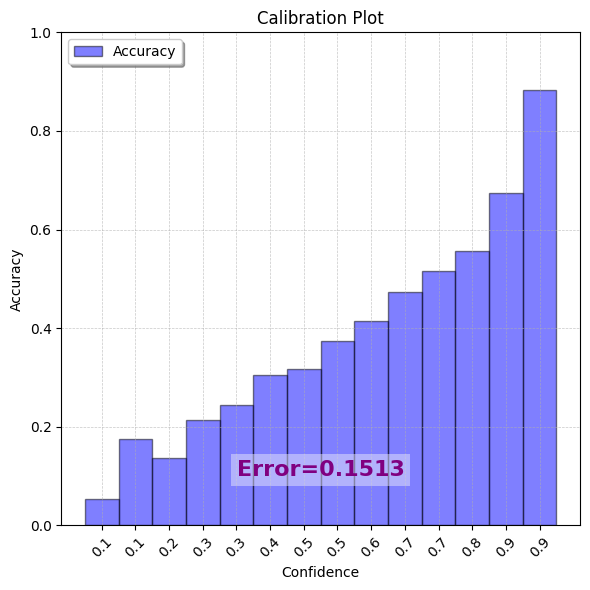

In [31]:
df_ls = make_calibration_df(probs_ls, labels_ls)
plot_calibration(df_ls, error=metrics_ls['ece'])

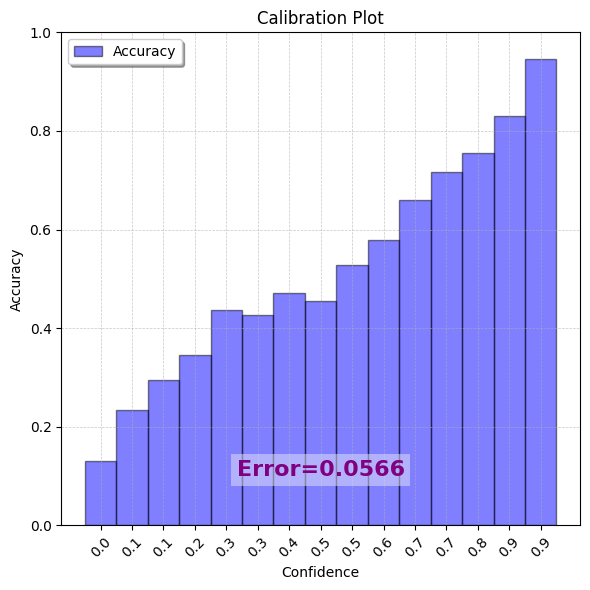

In [32]:
df_sgn = make_calibration_df(probs_sgn, labels_sgn)
plot_calibration(df_sgn, error=metrics_sgn['ece'])

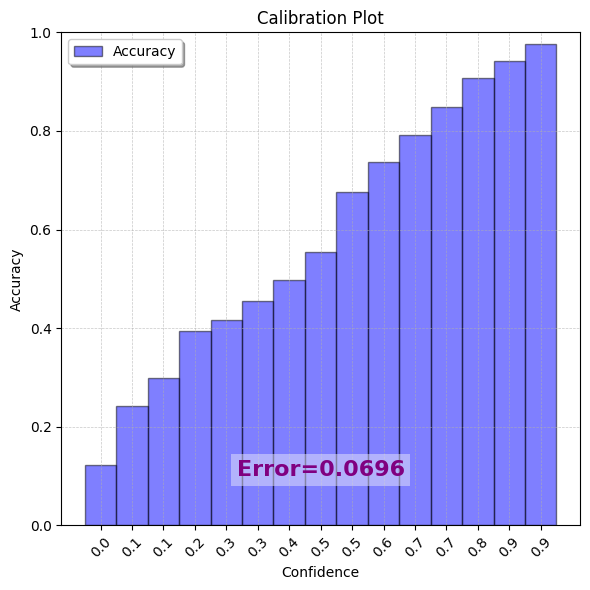

In [33]:
df_sgn_mc = make_calibration_df(probs_sgn_mc, labels_sgn)
plot_calibration(df_sgn_mc, error=metrics_sgn_mc['ece'])

In [ ]:
import tensorflow as tf

# CLR inverse function
def clr_inv(p):
    z = tf.math.log(p)
    return z - tf.reduce_mean(z, axis=1, keepdims=True)

# CLR forward function
def clr_forward(z, axis=1):
    return tf.nn.softmax(z, axis=axis)

def helmert_tf(n):
  tensor = tf.ones((n, n))
  H = tf.linalg.set_diag(tf.linalg.band_part(tensor, -1, 0), 1-tf.range(1, n+1, dtype=tf.float32))
  d = tf.range(0, n, dtype=tf.float32) * tf.range(1, n+1, dtype=tf.float32)
  H_full = H / tf.math.sqrt(d)[:, tf.newaxis]
  return H_full[1:]


def ilr_forward(z, axis=-1):
    H = helmert_tf(tf.shape(z)[-1] + 1)
    return clr_forward(z @ H, axis=axis)


def ilr_inv(p):
    z = clr_inv(p)
    H = helmert_tf(tf.shape(p)[-1])
    return z @ tf.linalg.matrix_transpose(H)

# Test the CLR functions
test_input = tf.constant([[0.2, 0.3, 0.5], [0.1, 0.1, 0.8]], dtype=tf.float32)

# Apply forward and inverse transformations
gaussian_result = ilr_inv(test_input)
backtr_result = ilr_forward(gaussian_result)

print("gaussian_result:", gaussian_result.numpy())
print("backtr_result:", backtr_result.numpy())

gaussian_result: [[-2.8670713e-01 -5.8261782e-01]
 [ 1.1100184e-08 -1.6978569e+00]]
backtr_result: [[0.2 0.3 0.5]
 [0.1 0.1 0.8]]
